# Object Detection Using YOLOv4

We are going to take a look at another object detection algorithm called __yolo__ short for "you only look once". Version 4 of this algorithm is among the fastest object detection algorithms out there today and is easily used inside of OpenCV.

In [21]:
import numpy as np
import cv2
import sys
import requests
from os import path
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15.0,15.0)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

## 1. Learning about YOLO
### What it means to "Only Look Once"

What makes YOLO unique is the fact that it looks at the entire overall scene as opposed to individual segments at a time, it essentially finds the origin for objects in the scene and expands to see how much area they cover to come up with bounding boxes.

Because it's looking at the overall scene instead of individual regions you end up having a much faster performance at the loss of a little bit of precision.

YOLO is one of the most powerful and fastest object detection algorithms today, is ideal for lots of real-time applications, certainly including driverless cars.

Because YOLO looks at the entire scene when considering where objects are located it gets a generalized understanding of the objects it detects which means it works comparatively well at identifying objects in unfamiliar contexts compared to its training sets. By definition, the objects are detected in the context of entire scene, so, it's less likely to get thrown off by shadows that maybe have the same shape as a car versus car that are actually on the road as one example.

## 2. Object Detection using YOLOv4 in OpenCV

Let us now see how to use YOLOv4 in OpenCV to perform object detection.

### 2.1 Initialize the parameters

The algorithm itself generates a multitude of bounding boxes around predicted detection regions much like other object detection algorithms there is an associated confidence score with each detected object.

In addition to thresholding we're going to actually use something called __non-maximum suppression__ which will help remove the redundant and overlapping bounding boxes for a given object, otherwisewe may find the same object is detected multiple times in the same position.

In addition, we are also going to define the input width and height and unlike prior models where you have to use a very specific size to match the training dataset, here we have some flexibility to change the input width and height of our blobs in order to decide how fast we want the algorithm to run, noting that smaller values where we scale the input image to be samller will run faster but be a little bit less precise.

In [22]:
# Initialize the parameters
objectnessThreshold = 0.5 # Objectness threshold, high values filter out low objectness
confThreshold = 0.5       # Confidence threshold, high values filter out low confidence detections
nmsThreshold = 0.4        # Non-maximum suppression threshold, higher values result in duplicate boxes per object 
inpWidth = 416            # Width of network's input image, larger is slower but more accurate
inpHeight = 416           # Height of network's input image, larger is slower but more accurate

### 2.2 Load the model and classes

The file __coco.names__ contains all the objects for which the model was trained. We read the class names.

Next, we load the network which has two parts:

+ __yolov4.weights__: The pre-trained weights.
+ __yolov4.cfg__: The configuration file.

In [23]:
# load names of classes.
classes_file = "../models/coco.names"
classes = None
with open(classes_file, "rt") as f:
    classes = f.read().rstrip("\n").split("\n")
    
# Give the configuration and weight files for the model and load the network using them.
model_configuration = "../models/yolov4.cfg"
model_weights = "../models/yolov4-tiny.weights"

if (not path.exists(model_weights)):
    url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights"

    r = requests.get(url)

    print('Downloading YOLO v4 Model.......')

    with open(model_weights, 'wb') as f:
        f.write(r.content)

    print('\nyolov4.weights Download complete!')

In [24]:
net = cv2.dnn.readNetFromDarknet(model_configuration, model_weights)

### 2.3 Process each frame

The input image is passed through the network and the output is decoded and displayed using a few utility functions. Let us go over the utility functions.

#### Getting the names of output layers

The __forward__ function in OpenCV’s Net class needs to know until which layer the blob should be passed through the network. Since we want to run through the whole network, we need to identify the last layer of the network. We do that by using the function __getUnconnectedOutLayers()__ that gives the names of the unconnected output layers, which are essentially the last layers of the network. After this, we would then we run the forward pass of the network to get output from the output layers like: __net.forward(getOutputsNames(net))__.

In [25]:
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the indices of the output layers (i.e., layers with unconnected outputs)
    try:
        return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except:
        return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

The outputs of the neural network, the structure is a list of bounding boxes and they're each represented by a vector with five elements, the first four represent the position and size of the bounding box (*center_x*, *center_y*, *width*, *height*) and the fifth is the confidence threshold.

The remainder of the elements are the confidence thresholds which would map to each of the other objects that the neural network can identify, the bounding box which represents the center and the width and height is for the corresponding highest score out of all the objects it can detect.

Because of this we're often only concerned with the object class detected with the highest score called the confidence. The idea being that we can filter out low confidence results.

In [26]:
def display_text(im, text, x, y):
    """Draw text onto image at location."""
    
    # Get text size 
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
            
    # Use text size to create a black rectangle. 
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, text, (x, y + dim[1]), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)

In [29]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1


def display_objects(frame, outs):
    """Remove the bounding boxes with low confidence using non-maxima suppression."""
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    
    # Loop through all outputs.
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold:
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        cv2.rectangle(frame, (left, top), (left + width, top + height), (255, 255, 255), 2)
        label = "{}:{:.2f}".format(classes[classIds[i]], confidences[i])
        display_text(frame, label, left, top)

The Non Maximum Suppression is controlled by the nmsThreshold parameter. If nmsThreshold is set too low, e.g. 0.1, we might not detect overlapping objects of same or different classes. But if it is set too high e.g. 1, then we get multiple boxes for the same object. So we used an intermediate value of 0.4 in our code above.

Non-maximum supression low value reduces the the number of duplicates, a smaller value for this threshold actually means that only the higher confidence items will show up.

---

### 3.1 Inference using Yolo v4

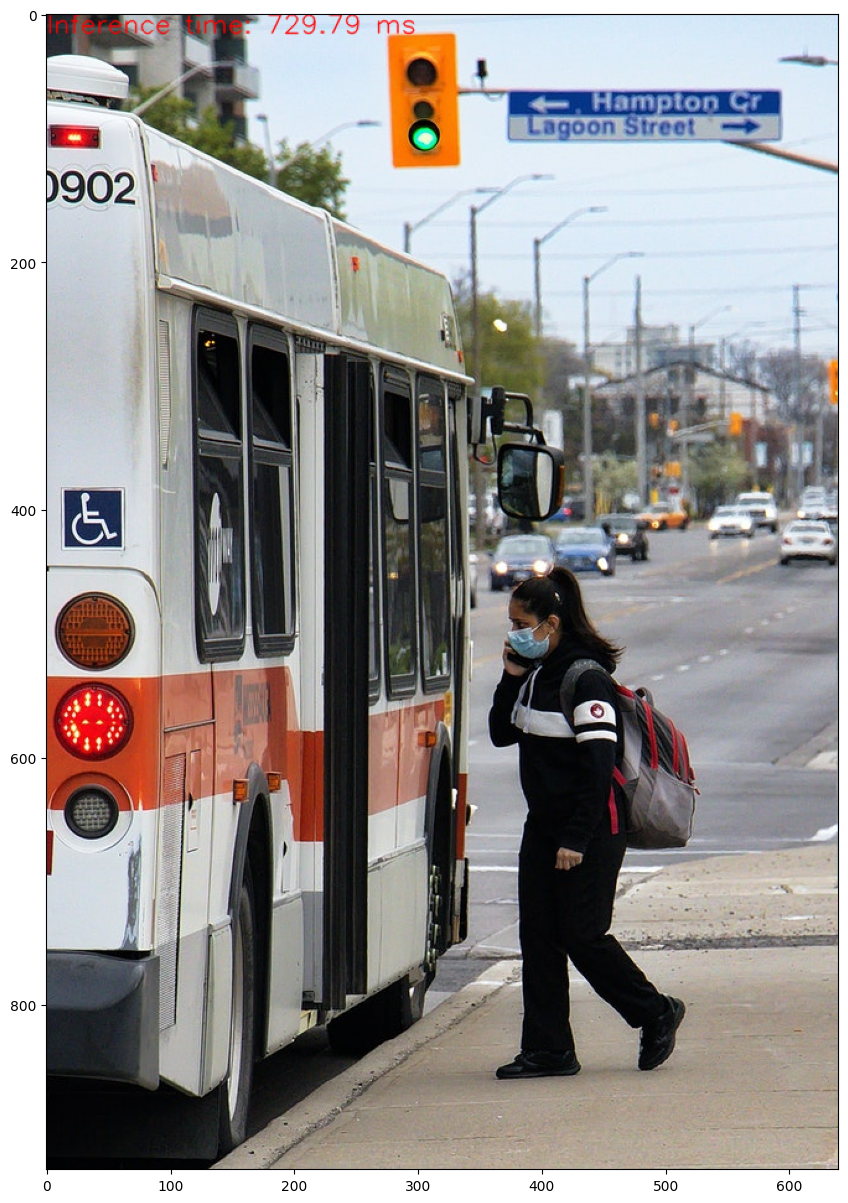

Inference time: 729.79 ms


In [30]:
# Process inputs
imagePath = "../images_test/traffic.jpg"
frame = cv2.imread(imagePath)

# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))

# Remove the bounding boxes with low confidence
display_objects(frame, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)
plt.imshow(frame[..., ::-1])
plt.show()
print(label)